# Групповой анализ данных с учетом условий

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.style.use('seaborn-whitegrid');

## Загрузка данных

Посмотрим данные испытуемого по имени C\* http://balatte.stireac.com/result/ssdanielyan%40mail.ru/

Он прошел тест в состоянии усталости и повторно после корректирующей процедуры.

In [3]:
udo = 'http://balatte.stireac.com/result.tsv/ssdanielyan%40mail.ru/sta194-1-r401-06.valeo.rsu.ru__6159522610000171030'
uposle = 'http://balatte.stireac.com/result.tsv/ssdanielyan%40mail.ru/sta194-1-r401-06.valeo.rsu.ru__7104549320000171030'
u=uposle
D=pd.read_table(u)
D.head()

,t,v
0,9.577,0.294
1,16.945,0.292
2,24.844,0.299
3,32.725,0.241
4,41.499,0.264


## Исходные данные

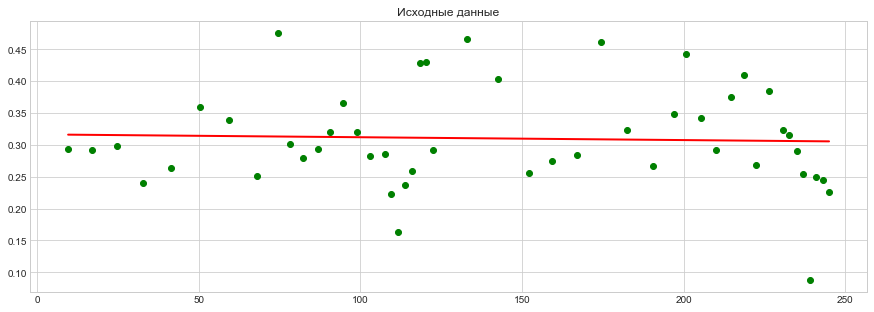

In [4]:
figsize(15,5);
plot(D.t, D.v, 'go')

Dg=D[isfinite(D.v)]
xx=Dg.t.iloc[[0,-1]]
yy=polyval(polyfit(Dg.t,Dg.v,1), xx)
plot(xx,yy,'r',lw=2);

title('Исходные данные');

Почему тренд отличается от того, что на сайте?

Потому что на сайте удалены выбросы.

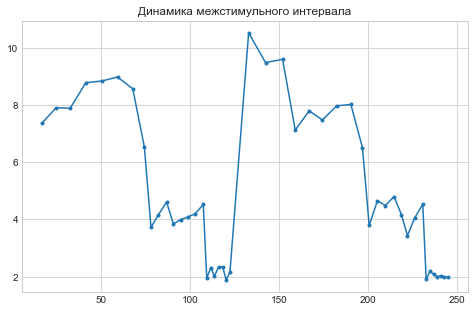

In [26]:
isi=diff(D.t)
plot(D.t[1:], isi,'.-')
title('Динамика межстимульного интервала');

In [44]:
#добавим инфу о интервале и модальности
isi0 = array([8,4,2])
momo = ['v','a']
nRep = D.shape[0]//(len(isi0)*len(momo))
D['isi'] = kron(isi0, ones((len(momo),nRep))).reshape((-1,1))
D['mod'] = repeat(momo, nRep*len(isi0))

In [ ]:
g = D.groupby(('mod','isi'))
g['v'].count()

Получили 6 групп по 31-32 значения

## Групповая статистика


In [15]:
M=g.v.mean()
S=g.v.std()
N=g.v.count()
ISI=[8,4,2]
M=array(M).reshape(2,3)
S=array(S).reshape(2,3)
N=array(N).reshape(2,3)
M

array([[ 0.29214286,  0.33      ,  0.28971429],
       [ 0.341875  ,  0.358     ,  0.249     ]])

In [16]:
from scipy import stats
xx=arange(3)
pp=[stats.ttest_ind_from_stats(M[0,i],S[0,i],N[0,i], M[1,i],S[1,i],N[1,i]).pvalue for i in xx]
# pp=[stats.ttest_ind(gg[i],gg[i+3])[1] for i in xx]
pp

[0.17401072733722425, 0.34925149401577127, 0.3561861132801718]

In [ ]:
gg=[]
for _i,_g in g:
    gg.append(_g.v)

In [17]:
pp=[]
for i in [0,1,2]:
    pp.append(stats.ttest_ind(gg[i],gg[i+3], nan_policy='omit').pvalue)
pp

[0.20228694561237559, 0.38031251838480851, 0.39007446026749426]

In [18]:
pp=[stats.ttest_ind(gg[i],gg[i+3], equal_var=False)[1] for i in [0,1,2]]
pp

[0.18966184965424632, 0.38050685292488229, 0.40390051258106552]

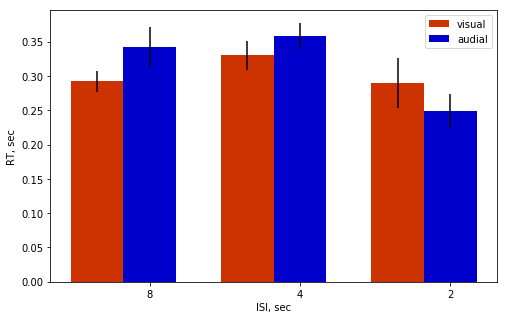

In [19]:
figsize(8,5)

SEM=S/sqrt(N)
width = 0.35 #ширина столбцов
p1 = bar(xx-width, M[0], width, color=(.8,.2,0), yerr=SEM[0])
p2 = bar(xx, M[1], width, color=(0,0,0.8), yerr=SEM[1])
xticks(xx,ISI)
xlabel('ISI, sec')
ylabel('RT, sec')
legend(('visual','audial'))

for i,p in enumerate(pp):
    if p<0.05:
        text(xx[i], max(M[:,i])+0.01, '*', size=20, horizontalalignment='center')

## Модели изменения ВР от МСИ (отдельно для каждой модальности)

In [20]:
#находим границу между зрительными и слуховыми
isi=diff(D.t)
iBr=find(isi>10)[0]+1
iBr

24

In [21]:
# интегрируем расчетные данные как дополнительные показатели
D['isi']=hstack([NaN,isi])
D['log2isi']=log2(D.isi)
D.head()

,t,v,isi,log2isi
0,9.577,0.294,NaN,NaN
1,16.945,0.292,7.368,2.881273
2,24.844,0.299,7.899,2.981670
3,32.725,0.241,7.881,2.978379
4,41.499,0.264,8.774,3.133235


In [22]:
(D.index<iBr).shape

(48,)

In [23]:
bb=isfinite(D.v)
bbV=bb & (D.index<iBr) & (D.index>0)
bbA=bb & (D.index>iBr)

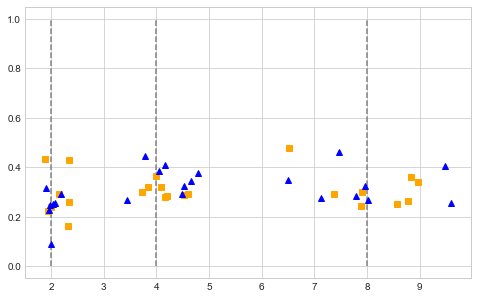

In [27]:
plot(D[bbV].isi, D[bbV].v, 's',color='orange',);
plot(D[bbA].isi, D[bbA].v, 'b^');
vlines(ISI, 0, 1, color='gray',linestyles='dashed')
#xscale('log');

(0.2, 0.5)

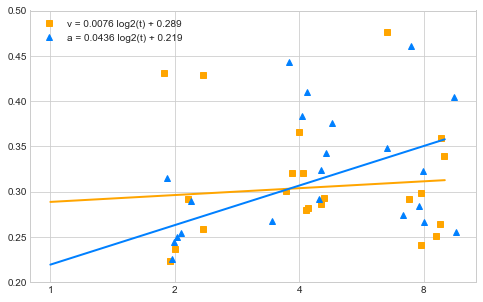

In [28]:
for mod in ['v','a']:
    color=mod=='v' and 'orange' or [0,.5,1]
    marker=mod=='v' and 's' or '^'
    bb=eval('bb'+mod.upper())
    D1=D[bb]
    
    xx=log2(arange(1,10))
    p=polyfit(D1.log2isi, D1.v,1)
    yy=polyval(p,xx)

    s='{} = {:.4f} log2(t) + {:.3f}'.format(mod, p[0],p[1])
    plot(D1.log2isi, D1.v, lw=0, color=color, marker=marker, label=s)
    plot(xx,yy,color=color,lw=2);


vv=2**arange(4)
xticks(log2(vv), vv)
grid(True)
legend();
ylim([.2,.5])

In [30]:
from IPython.display import IFrame
IFrame(u.replace('.tsv',''), width=960, height=480)

### Вывод. На сайте немного другой алгоритм удаления выбросов.